# Predicting Customer Churn in Telecom
<strong>Programming language:</strong> R<br/>
<strong>Dataset source:</strong> Kaggle - [Telco Customer Churn][id].

[id]: https://www.kaggle.com/blastchar/telco-customer-churn "dataset"

## Overview
In this post, I will build a logistic regression and a decision tree to predict customer churn, giving recommendations to a Telecom company based on analysis results. 

## Project Background
<strong>Customer churn</strong> is defined as the loss of clients. In a telecommunications company, customer attrition is one of the key business metrics. To be more specific, it is important to retain an existing customer since compared with newly recruited clients, the long-term relationship customers are more valuable to the company. Thus, this project aims to use customer churn analysis to forecast the behavior of telecom customers who are more likely to leave, and provide a reasonable churn prediction for customer retention marketing programs.

## Dataset Overview
The “Telco Customer Churn” dataset, which is downloaded from Kaggle, includes information about customer characteristics and whether customers churn or not. There are 7043 observations of 21 variables. To elaborate, columns one to twenty includes categories such as services that each customer has signed up for, customer account information, and customer demographic information. The twenty-first column indicates whether the customer has churned within the last month.

**Previously, I have finished [Exploratory Data Analysis][id] on this dataset. Now I will start to build predictive models, performing predictive analysis.**

[id]: https://github.com/yuki04160/EDA-Customer-Churn-in-Telecom- "EDA"

In [1]:
# Load data 
Telco<- read.csv(file = '/Users/yuki0416/Desktop/Q2-Spring/Intermediate Analytics/Final Project/WA_Fn-UseC_-Telco-Customer-Churn.csv',header = TRUE)
str(Telco)

'data.frame':	7043 obs. of  21 variables:
 $ customerID      : Factor w/ 7043 levels "0002-ORFBO","0003-MKNFE",..: 5376 3963 2565 5536 6512 6552 1003 4771 5605 4535 ...
 $ gender          : Factor w/ 2 levels "Female","Male": 1 2 2 2 1 1 2 1 1 2 ...
 $ SeniorCitizen   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Partner         : Factor w/ 2 levels "No","Yes": 2 1 1 1 1 1 1 1 2 1 ...
 $ Dependents      : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 2 ...
 $ tenure          : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService    : Factor w/ 2 levels "No","Yes": 1 2 2 1 2 2 2 1 2 2 ...
 $ MultipleLines   : Factor w/ 3 levels "No","No phone service",..: 2 1 1 2 1 3 3 2 3 1 ...
 $ InternetService : Factor w/ 3 levels "DSL","Fiber optic",..: 1 1 1 1 2 2 2 1 2 1 ...
 $ OnlineSecurity  : Factor w/ 3 levels "No","No internet service",..: 1 3 3 3 1 1 1 3 1 3 ...
 $ OnlineBackup    : Factor w/ 3 levels "No","No internet service",..: 3 1 3 1 1 1 3 1 1 3 ...
 $ DeviceProtection: Factor w/ 3 levels "No","

In [ ]:
# Load package
library(Information)
library(ggplot2)
library(ggcorrplot)
library(plotROC)
library(car)
library(InformationValue)
library(MLmetrics)
library(rpart.plot)
library(rpart)
library(vip)

In [3]:
# Data pre-processing from EDA

# Adjust data type (SeniorCitizen: Int -> Factor)
Telco$SeniorCitizen=as.factor(ifelse(Telco$SeniorCitizen==1, "Yes", "No")) 
attach(Telco)

# Replace "TotalCharges" with "tenure* MonthlyCharges"
Telco$TotalCharges <- ifelse(is.na(TotalCharges), tenure*MonthlyCharges, TotalCharges)

# Change target variable data type (churn: Factor -> Nnumeric)
Telco$Churn=as.numeric(ifelse(Telco$Churn=="Yes", 1, 0))

# Clean the categorical features 
# Replace column (No phone service, No internet servic -> No)
Telco$MultipleLines[which(Telco$MultipleLines == "No phone service")] = "No"
for(i in 10:15){
  Telco[,i][which(Telco[,i] == "No internet service")] = "No"
}

# Drop level
Telco$MultipleLines <- droplevels(Telco$MultipleLines)
for(j in 10:15){
  Telco[,j] <- droplevels(Telco[,j])
}

## Modeling: Supervised Learning

### Create Training and Testing Samples

In [4]:
# Remove customer ID
samples <- Telco[-1]

# Split into training (0.7) and testing (0.3) data
set.seed(0101)
ind <- sample(2, nrow(samples), replace=T, prob=c(0.7, 0.3))
train.samples <- samples[ind==1, ]
test.samples<- samples[ind==2, ]

In [5]:
prop.table(table(samples$Churn))

# Double check if the churn rates of two tets are close
prop.table(table(train.samples$Churn))
prop.table(table(test.samples$Churn))


        0         1 
0.7346301 0.2653699 


        0         1 
0.7359723 0.2640277 


        0         1 
0.7315593 0.2684407 

The output shows that the overall churn rate is around 26%, also indicating that the dataset is imbalanced. Besides, the churn rates of the training and testing sets are close. Thus, we can use them.

### 1. Logistic Regression

#### A. Compute Information Values
<ins>Information value (IV)</ins> is a technique to select important variables in a predictive model. To be more specific, it assists to rank variables according to their importance. The higher the IV, the stronger the variable predictiveness. Thus, we can use the table below to select predictors when building a logistic model.

In [6]:
infoTables <- create_infotables(data = samples, y = 'Churn', parallel = FALSE)
print(infoTables$Summary, row.names=FALSE)

         Variable           IV
         Contract 1.2385597928
           tenure 0.8262254099
  InternetService 0.6179525742
    PaymentMethod 0.4571089328
   MonthlyCharges 0.3656367866
     TotalCharges 0.3331429868
 PaperlessBilling 0.2030683847
   OnlineSecurity 0.1719767701
      TechSupport 0.1574556578
       Dependents 0.1554877150
          Partner 0.1187285028
    SeniorCitizen 0.1056211829
     OnlineBackup 0.0359643090
 DeviceProtection 0.0230814549
      StreamingTV 0.0202464313
  StreamingMovies 0.0190958759
    MultipleLines 0.0082037008
     PhoneService 0.0007448405
           gender 0.0003804366


#### B. Build Logit Model 1
Since a variable with IV greater than 0.1 can be seen as a medium or a strong predictor, we used an IV greater than 0.1 as the selection criteria in the first logistic regression model.

In [7]:
# Predictors: use IV > 0.1
log.Mod1 <- glm(Churn ~ Contract + tenure + InternetService +
                    PaymentMethod + MonthlyCharges + TotalCharges +
                  PaperlessBilling + OnlineSecurity + TechSupport + 
                  Dependents + Partner + SeniorCitizen,
                data=train.samples, family=binomial(link="logit"))

summary(log.Mod1) #AIC: 4096.4


Call:
glm(formula = Churn ~ Contract + tenure + InternetService + PaymentMethod + 
    MonthlyCharges + TotalCharges + PaperlessBilling + OnlineSecurity + 
    TechSupport + Dependents + Partner + SeniorCitizen, family = binomial(link = "logit"), 
    data = train.samples)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7604  -0.6873  -0.2785   0.7615   3.1549  

Coefficients:
                                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)                          -1.816e-01  2.699e-01  -0.673 0.501005    
ContractOne year                     -6.244e-01  1.280e-01  -4.879 1.06e-06 ***
ContractTwo year                     -1.499e+00  2.150e-01  -6.970 3.16e-12 ***
tenure                               -6.636e-02  7.924e-03  -8.375  < 2e-16 ***
InternetServiceFiber optic            5.968e-01  1.699e-01   3.512 0.000444 ***
InternetServiceNo                    -1.105e+00  1.968e-01  -5.617 1.94e-08 ***
PaymentMethodCredit card (automatic)

From the outputs above, we can see that based on the p-values, "ContractOne year," "ContractTwo year," "tenure," "InternetServiceFiber optic," "InternetServiceNo," "TotalCharges," "PaperlessBillingYes," and "OnlineSecurityYes" have more significant influence on predicting churn. In addition, "PaymentMethodElectronic check," "TechSupportYes," and "SeniorCitizenYes" also have some significant influence on predicting customer churn.

#### C. Detect Multicollinearity in Logit Model 1
Before we predict on test data and examine the model performance, we have to use <em>vif</em> function to check <ins>multicollinearity</ins>. 

In [8]:
vif(log.Mod1)

,GVIF,Df,GVIF^(1/(2*Df))
Contract,1.589868,2,1.122898
tenure,17.787120,1,4.217478
InternetService,7.256727,2,1.641290
PaymentMethod,1.339937,3,1.049979
MonthlyCharges,9.283919,1,3.046952
TotalCharges,22.619016,1,4.755945
PaperlessBilling,1.132949,1,1.064401
OnlineSecurity,1.160421,1,1.077229
TechSupport,1.272032,1,1.127844
Dependents,1.287633,1,1.134739


From the table above, we can tell that the VIF of "tenure" and the VIF of "TotalCharges" are above 10, indicating that there might be a multicollinearity problem. Thus, I built a correlation matrix to view correlation in-detail.

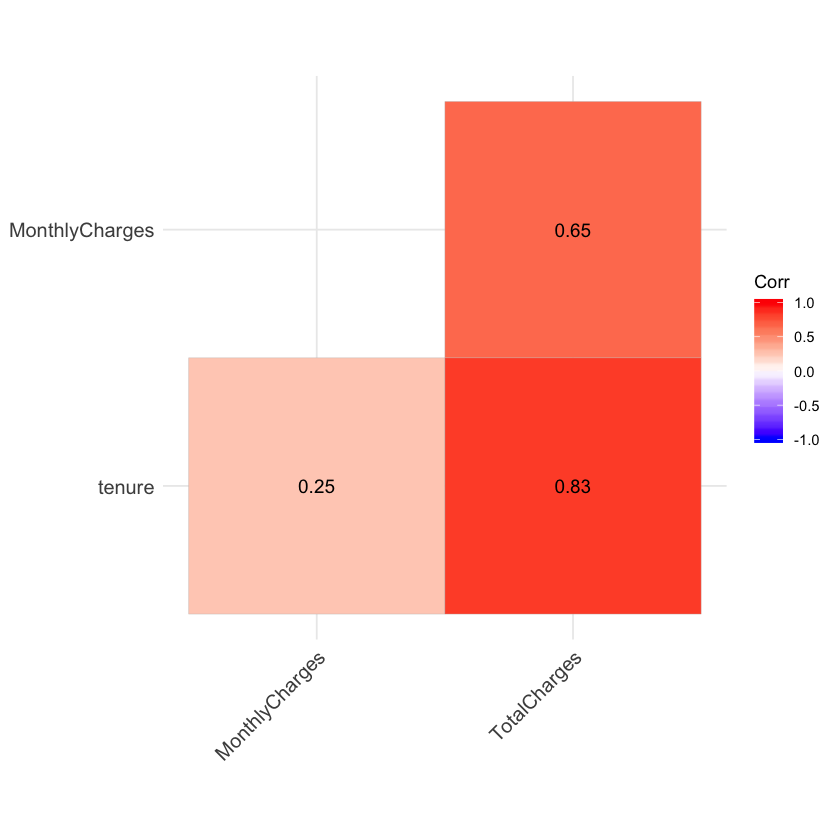

In [9]:
# tenure, MonthlyCharges, TotalCharges
multi.var <- c(5,18,19)

corr <- round(cor(samples[multi.var]), 2) 
ggcorrplot(corr, type="lower",lab = TRUE) 

From the correlation matrix, we can tell that "TotalCharges" has high correlations with "tenure" and "MonthlyCharges." Thus, to address multicollinearity problem, "TotalCharges" has to be removed from the model.

#### D. Build Logit Model 2
To build the second logistic regression model, I used variables from logit model 1, excluding "TotalCharge."

In [10]:
# Predictors: remove TotalCharges from Model 1
log.Mod2 <- glm(Churn ~ Contract + tenure + InternetService +
                  PaymentMethod + MonthlyCharges +
                  PaperlessBilling + OnlineSecurity + TechSupport + 
                  Dependents + Partner + SeniorCitizen,
                data=train.samples, family=binomial(link="logit"))

summary(log.Mod2) #AIC: 4117.7


Call:
glm(formula = Churn ~ Contract + tenure + InternetService + PaymentMethod + 
    MonthlyCharges + PaperlessBilling + OnlineSecurity + TechSupport + 
    Dependents + Partner + SeniorCitizen, family = binomial(link = "logit"), 
    data = train.samples)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8185  -0.6738  -0.2890   0.7184   2.9873  

Coefficients:
                                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)                          -0.909593   0.222787  -4.083 4.45e-05 ***
ContractOne year                     -0.625846   0.126706  -4.939 7.84e-07 ***
ContractTwo year                     -1.444452   0.211721  -6.822 8.95e-12 ***
tenure                               -0.032309   0.002670 -12.103  < 2e-16 ***
InternetServiceFiber optic            0.534372   0.167434   3.192 0.001415 ** 
InternetServiceNo                    -0.884045   0.189490  -4.665 3.08e-06 ***
PaymentMethodCredit card (automatic) -0.166104   0.137058 

From the summary of model 2, we can tell that since we have removed the "TotalCharges," "MonthlyCharges" seems to have more significant influence in the model 2, compared to it in model 1.

#### E. Detect Multicollinearity in Logit Model 2
Again, before we predict on test data and examine the model performance, we have to use <em>vif</em> function to check <ins>multicollinearity</ins>. 

In [11]:
vif(log.Mod2)

,GVIF,Df,GVIF^(1/(2*Df))
Contract,1.552506,2,1.116242
tenure,1.942999,1,1.393915
InternetService,6.844648,2,1.617476
PaymentMethod,1.307374,3,1.045683
MonthlyCharges,6.982828,1,2.642504
PaperlessBilling,1.127958,1,1.062054
OnlineSecurity,1.158151,1,1.076174
TechSupport,1.265422,1,1.124910
Dependents,1.292249,1,1.136771
Partner,1.371807,1,1.171242


The VIF of independent variables is all below 7 now, which is acceptable.

#### F.  Evaluate Logit Model 2 Performance

- **Predict on test data**<br /> 

In [12]:
log.Mod2_predict <- plogis(predict(log.Mod2, test.samples)) # Predic results: 0~1

- **ROC Curve**<br /> 
AUROC means "Area under the ROC Curve". It shows the performance of a classification model at all threshold settings. The greater the area, the better the predictive ability. However, the steepness of ROC curves is also critical to a model.

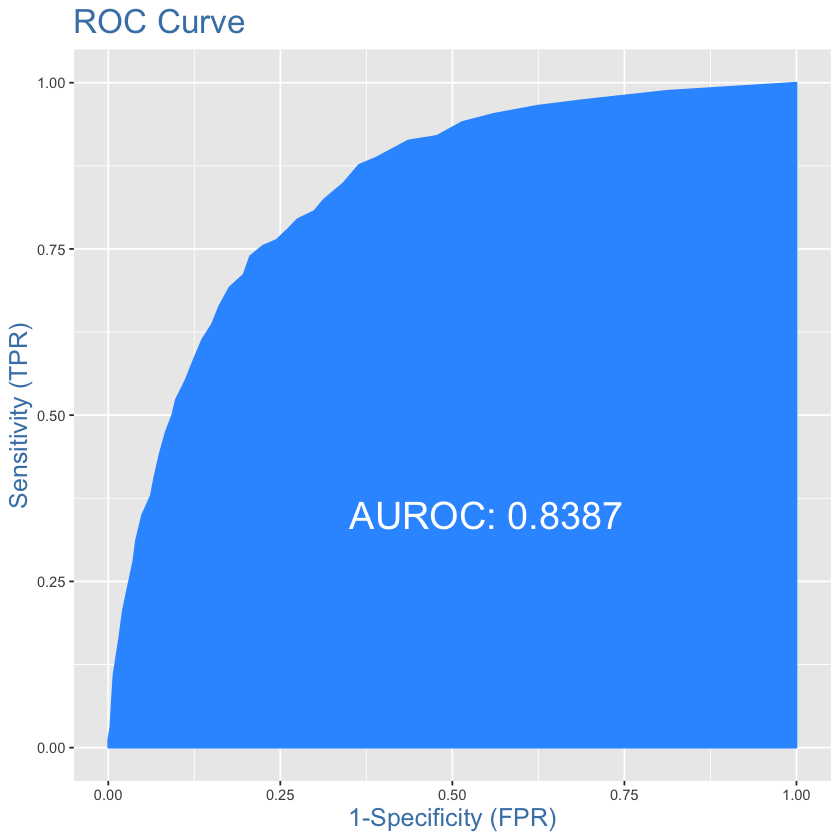

In [13]:
plotROC(test.samples$Churn, log.Mod2_predict) 

As we can see from the graph above, the area under the ROC curve is 0.8387. Also, the curve has risen steeply. To sum up, model 2 may have good predictive ability to predict "Churn".

- **Decide on optimal prediction probability cutoff**<br /> 

In [14]:
optCutOff2 <- optimalCutoff(test.samples$Churn, log.Mod2_predict)[1] 
optCutOff2 #0.4944032: score above this is "Yes", below is "No"

[1] 0.4944032

- **Sensitivity and Specificity**<br /> 
The sensitivity of a test is also called the <strong>True Positive Rate</strong>, and the specificity of a test is also called the <strong>True Negative Rate</strong>.

In [15]:
log.Mod2_sensitivity <- sensitivity(test.samples$Churn, log.Mod2_predict, threshold = optCutOff2)
log.Mod2_specificity <- specificity(test.samples$Churn, log.Mod2_predict, threshold = optCutOff2)

log.Mod2_sensitivity
log.Mod2_specificity

[1] 0.533913

[1] 0.8998086

The outputs show that model 2 has high specificity but relatively low sensitivity. In other words, model 2 will correctly return a negative (0) result for around 90% of customers who didn't churn.

- **Accuracy**<br /> 
Accuracy is used when the TPR and TNR are more important. Also, it can be used when the class distribution is similar (Huilgol, 2019).

In [16]:
# ConfusionMatrix
log.Mod2_CM <- confusionMatrix(test.samples$Churn, log.Mod2_predict, threshold = optCutOff2)
log.Mod2_CM

log.Mod2_accuracy <- (log.Mod2_CM[1,1]+log.Mod2_CM[2,2])/(sum(log.Mod2_CM))
log.Mod2_accuracy 

,0,1
,<int>,<int>
0,1410,268
1,157,307


[1] 0.8015873

- **Precision and Recall**<br />
The Precision metric is related to <strong>Type-I error</strong> (FP), while the Recall metric is related to <strong>Type-II error</strong>(FN) (Bajaj, 2019).<br /> 
In our case, Type I error is when the prediction is positive (churn), but the actual is negative (not churn), and Type II error is when the prediction is negative (not churn), but the actual is positive (churn). 

In [17]:
log.Mod2_precision <- log.Mod2_CM[2,2]/(log.Mod2_CM[2,1]+log.Mod2_CM[2,2])
log.Mod2_recall <-  log.Mod2_CM[2,2]/(log.Mod2_CM[1,2]+log.Mod2_CM[2,2])
log.Mod2_precision
log.Mod2_recall

[1] 0.6616379

[1] 0.533913

The outputs show that in logit model 2, precision is higher than recall. In our case, the company is more willing to label all suspicious customers as "churn", rather than do nothing and later customers leave the company. Thus, our goal is to decrease Type II error (FN), increasing recall (TPR).

- **F1-Score**<br /> 
The F1-score is the harmonic average of precision and recall. That is, it is used when the FNR and FPR are crucial. Also, it is a better metric when there are imbalanced classes, which is our case (Huilgol, 2019).

In [18]:
pred <- ifelse(log.Mod2_predict < optCutOff2, 0, 1)
log.Mod2_f1 <- F1_Score(y_pred = pred, y_true = test.samples$Churn, positive = "1")
log.Mod2_f1

[1] 0.5909528

### 2. Decision Tree

#### A. Build Decision Tree
I used the same predictors as logit model 2 to build the decision tree.

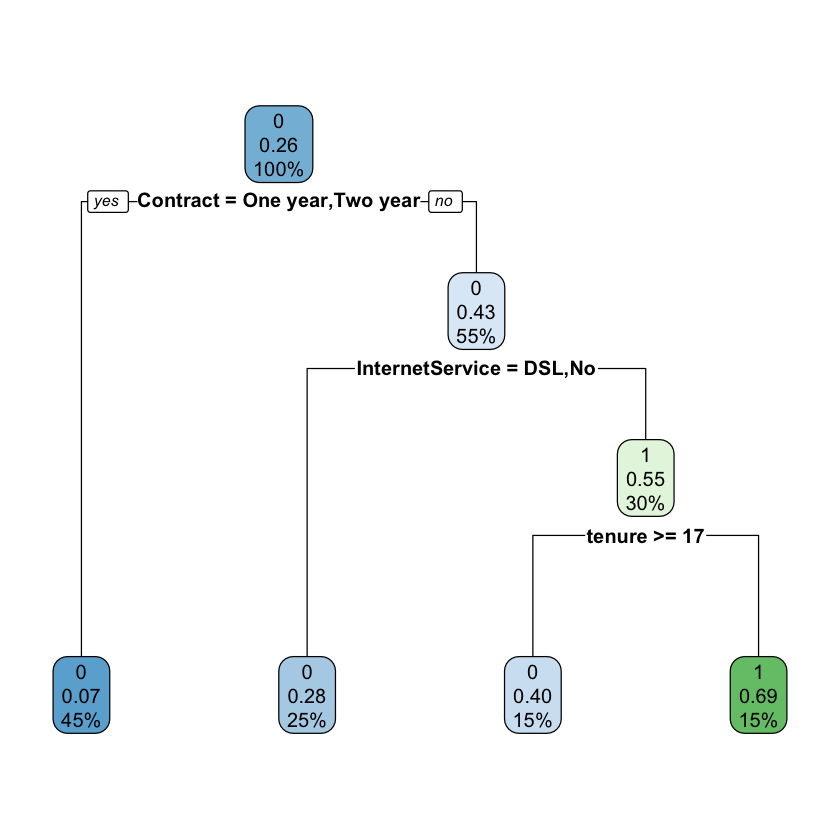

In [19]:
tree.formula <- Churn~ Contract + tenure + InternetService + 
  MonthlyCharges + PaymentMethod + PaperlessBilling + 
  OnlineSecurity + Dependents + TechSupport + Partner + SeniorCitizen

tree <- rpart(tree.formula, data=train.samples,method = 'class')
rpart.plot(tree)

The tree shows that the top (root node) is the whole customer data and the total churn rate is around 26%. This node asks whether the customer "Contract" is one-year or two-year. If yes, then you go down to the root's left child node and the churn rate of those customers decreases to 7%. On the other hand, if the "Contract" is month-to-month, you will go on the root's right and the churn rate increases to 43%. <br />
Then, a new node will ask you whether the "InternetService" is DSL or No. If yes, then you go down to the left and the churn rate of those customers is 28%. On the other hand, if the "InternetService" is Fiber optic, you will go on the right and the churn rate increases to 55%. <br />
Then, a new node will ask you whether the customer "tenure" is greater than or equal to 17. If yes, then you go down to the left and the churn rate is 40%. Yet, if the "tenure" is less than 17, the churn rate of those customers will raise to nearly 70%.<br /> 
To sum up, we can infer from the decision tree that a customer who signs the <ins>month-to-month</ins> contract, uses <ins>Fiber optic</ins>, and has stayed with the company <ins>less than 17 months</ins> is at the highest risk of churning (69%).

#### B.  Evaluate Decision Tree Performance

- **Predict on test data**<br /> 

In [20]:
# Predict results: 0(No)/ 1(Yes)
tree_predict <- predict(tree,newdata = test.samples,type ="class")

- **ROC Curve**<br /> 

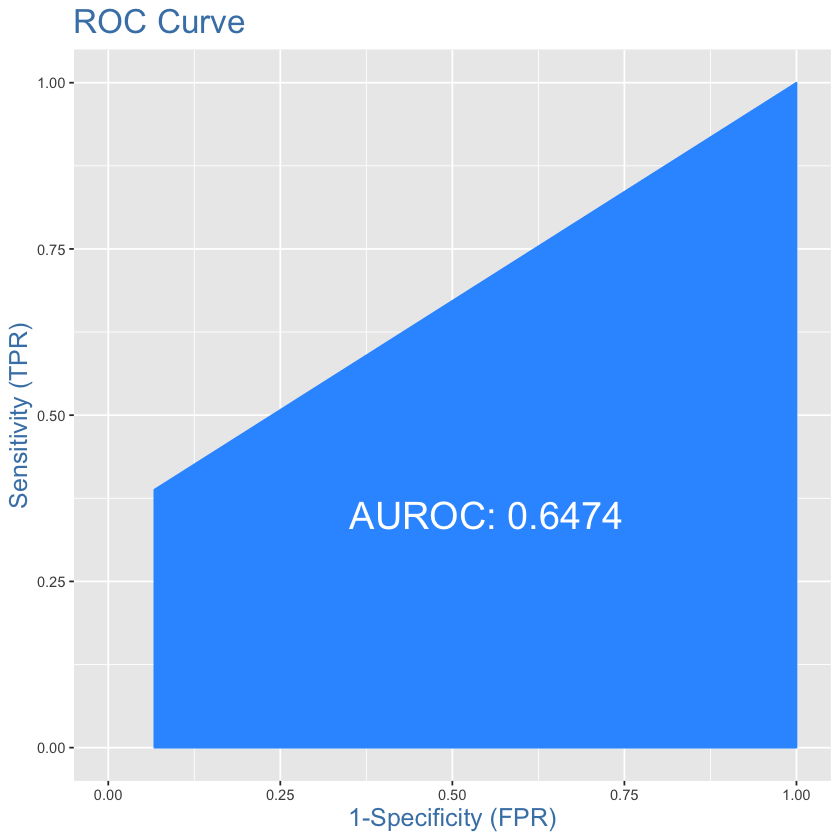

In [21]:
# Change tree.predict type: factor -> numeric
tree_predict=as.numeric(ifelse(tree_predict=="1", 1, 0))

plotROC(test.samples$Churn, tree_predict)

- **Sensitivity and Specificity**<br /> 



In [22]:
sensitivity(test.samples$Churn, tree_predict)
specificity(test.samples$Churn, tree_predict)

[1] 0.3878261

[1] 0.932993

- **Accuracy**<br />

In [23]:
# ConfusionMatrix
tree_CM <- confusionMatrix(test.samples$Churn, tree_predict)
tree_CM

tree_accuracy <- (tree_CM[1,1]+tree_CM[2,2])/(sum(tree_CM))
tree_accuracy 

,0,1
,<int>,<int>
0,1462,352
1,105,223


[1] 0.786648

- **Precision and Recall**<br />

In [24]:
tree_precision <- tree_CM[2,2]/(tree_CM[2,1]+tree_CM[2,2])
tree_recall <-  tree_CM[2,2]/(tree_CM[1,2]+tree_CM[2,2])
tree_precision
tree_recall

[1] 0.679878

[1] 0.3878261

- **F1-Score**<br /> 

In [25]:
tree_f1 <- F1_Score(y_pred = tree_predict, y_true = test.samples$Churn, positive = "1")
tree_f1

[1] 0.4939092

- **Feature Importance**<br /> 
I used <em>vip</em> function to plot variable importance scores for the predictors in a decision tree.

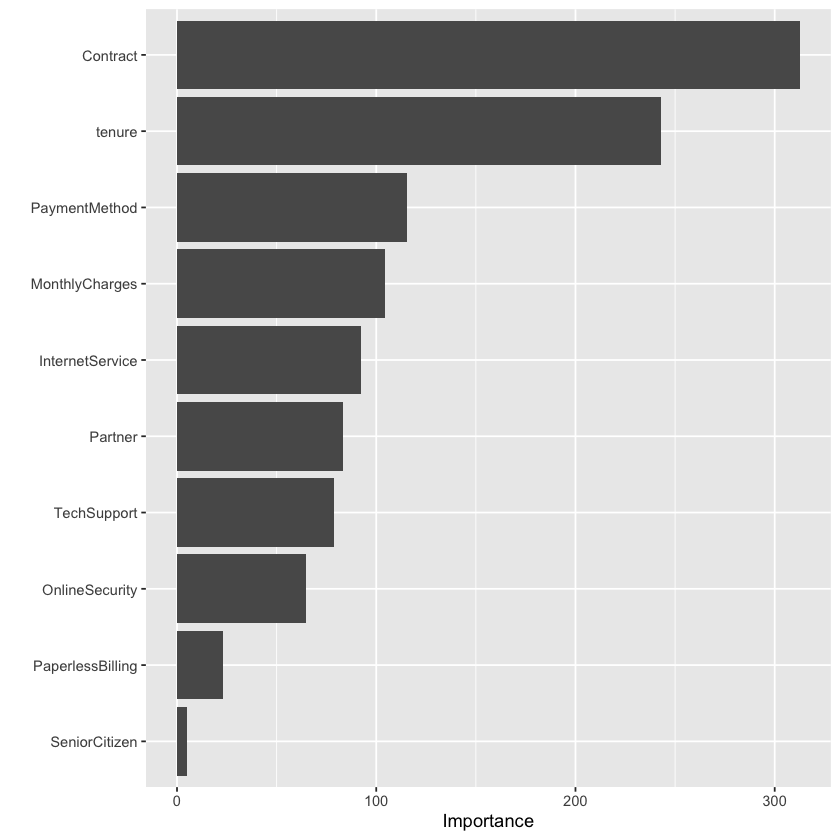

In [26]:
vip(tree, num_features=ncol(test.samples)-1)

## Conclusion
To compare the two models' performance, I built a table below. As I mentioned before, the company would like to know which customers are highly likely to leave in the future. Thus, overall, logit model 2 performed better, since it has a higher AUROC, Sensitivity, Recall, and F1-Score. <br /> 

**Models**|Logit Model 2 | Decision Tree
-----|-----|----- 
**AUROC**|0.8387|0.6474
**Sensitivity**|0.53|0.38
**Specificity**|0.9|0.93
**Accuaracy**|0.8|0.78
**Precision**|0.66|0.68
**Recall**|0.53|0.38
**F1-Score**|0.59|0.49

In terms of significant predictors, from the summary of logit model 2, the plot of the decision tree, and the feature importance plot of the decision tree, I can conclude that “Contract” and “tenure” have the most significant influence on predicting customer churn. Thus, based on the analysis results, to keep customers, I will suggest the company establish a long-term stable relationship with customers, for example <strong>encouraging customers to sign a long-term contract when starting.</strong>

In the future, since the True Positive Rate of two models are not high enough (0.53 and 0.38), we can keep optimizing models by balancing training dataset, performing regularization regression, tuning decision tree, or using ensemble learning methods.

## References
Bajaj, A. (2019, December 25). <em>What does your classification metric tell about your data?</em> Retrieved from https://towardsdatascience.com/what-does-your-classification-metric-tell-about-your-data-4a8f35408a8b <br /> 
Huilgol, P. (2019, August 24). <em>Accuracy vs. F1-Score</em>. Retrieved from https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2